#### Import libraries

In [50]:
import pandas as pd
import math
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.io as pio

In [51]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [52]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'DEN'

# Dependant variable
dep_var = 'TIV'     

# Exogenous variable for SARIMAX
exo_var = 'Orders'

### Load Data

In [53]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index  
df = df.set_index("Date").asfreq('MS')

In [54]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,161,2.184466,4.1,3.311,65.640787
2006-02-01,250,2.163461,4.2,3.484,61.924395
2006-03-01,468,1.911589,4.2,3.704,83.479473
2006-04-01,412,1.902497,4.2,3.975,77.672609
2006-05-01,550,2.021403,4.1,4.022,91.928459
...,...,...,...,...,...
2022-08-01,343,8.909952,4.5,1.375,74.473027
2022-09-01,337,10.018900,4.6,2.200,75.796992
2022-10-01,322,10.112360,4.6,2.599,63.242553


### Split Data

In [28]:
steps = 36  # 36 months of testing
train = df[:-steps]
test  = df[-steps:]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=191)
Train dates    : 2007-02-01 00:00:00 --- 2019-12-01 00:00:00  (n=155)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


### Scoring function

In [29]:
metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):
    
    mae = np.mean(np.abs(y_pred - y_true))                                    # MAE
    mse = mean_squared_error(y_true, y_pred)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                     # RMSE (Root Mean Squared Error)    
    r2 = r2_score(y_true, y_pred)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)*100)                # MAPE        
    accuracy = 100 - mape                                                     # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']       

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy                    
    
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions - " + country)    

        fig.show()  

                    

### Modeling

#### Simple Exponential Smoothing

Simple Exponential Smoothing Model Performance:
Mean Absolute Error: 22.72.
Mean Squared Error: 736.20.
Root Mean Squared Error: 27.13.
R^2 Score = -0.72.
Mean Absolute Percentage Error: 31.43%.
Accuracy = 68.57%.


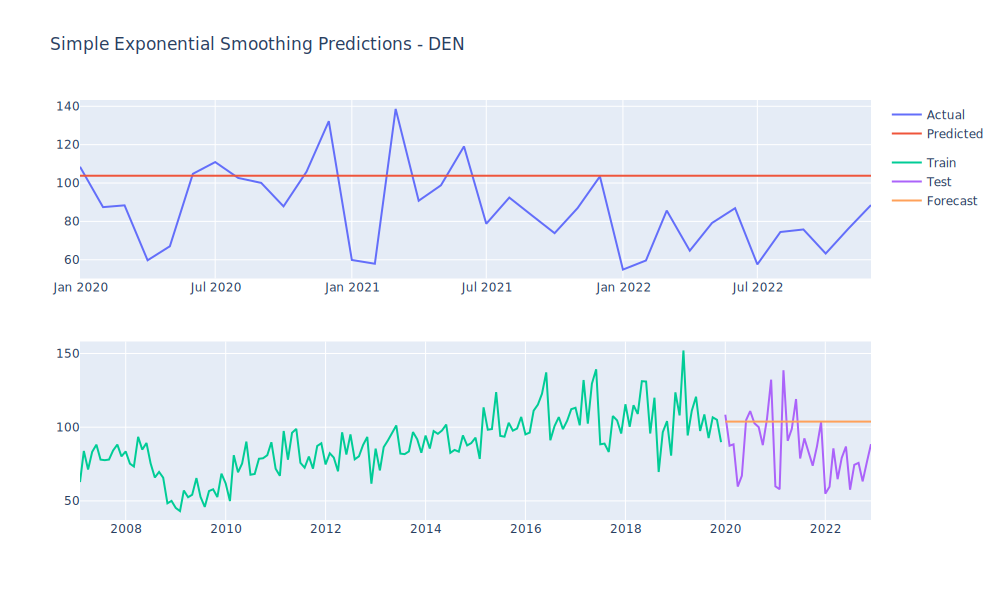

In [30]:
model_name='Simple Exponential Smoothing'
span = 12
alpha = 2/(span+1)

# Train
model = SimpleExpSmoothing(train[dep_var]).fit(smoothing_level=alpha,optimized=False)

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Double Explonential Smoothing

Double Exponential Smoothing Model Performance:
Mean Absolute Error: 24.37.
Mean Squared Error: 831.54.
Root Mean Squared Error: 28.84.
R^2 Score = -0.94.
Mean Absolute Percentage Error: 33.69%.
Accuracy = 66.31%.


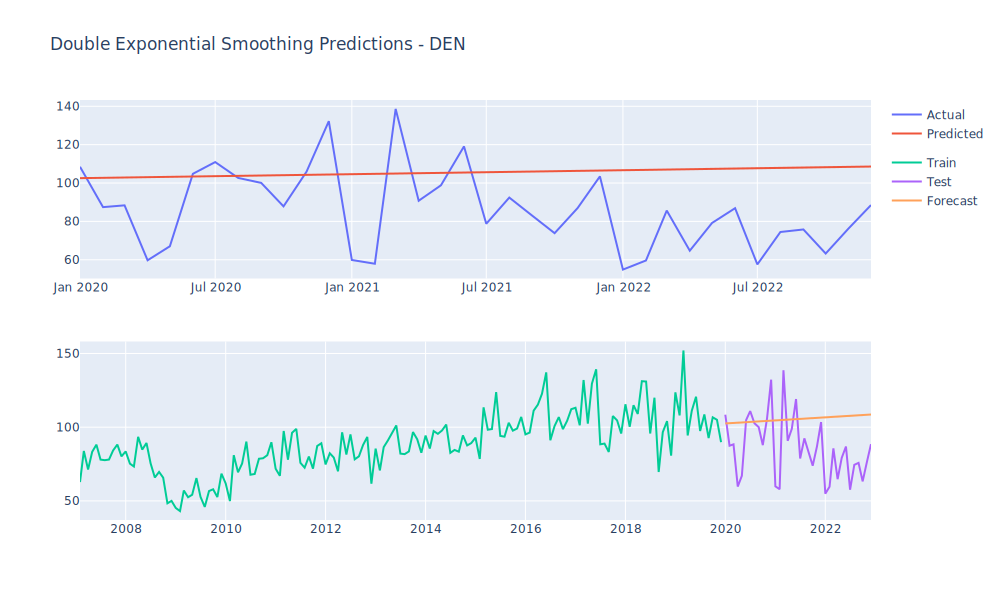

In [31]:
model_name='Double Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal_periods=12).fit()
# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Triple Exponential Smoothing

Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 26.22.
Mean Squared Error: 962.72.
Root Mean Squared Error: 31.03.
R^2 Score = -1.24.
Mean Absolute Percentage Error: 36.02%.
Accuracy = 63.98%.


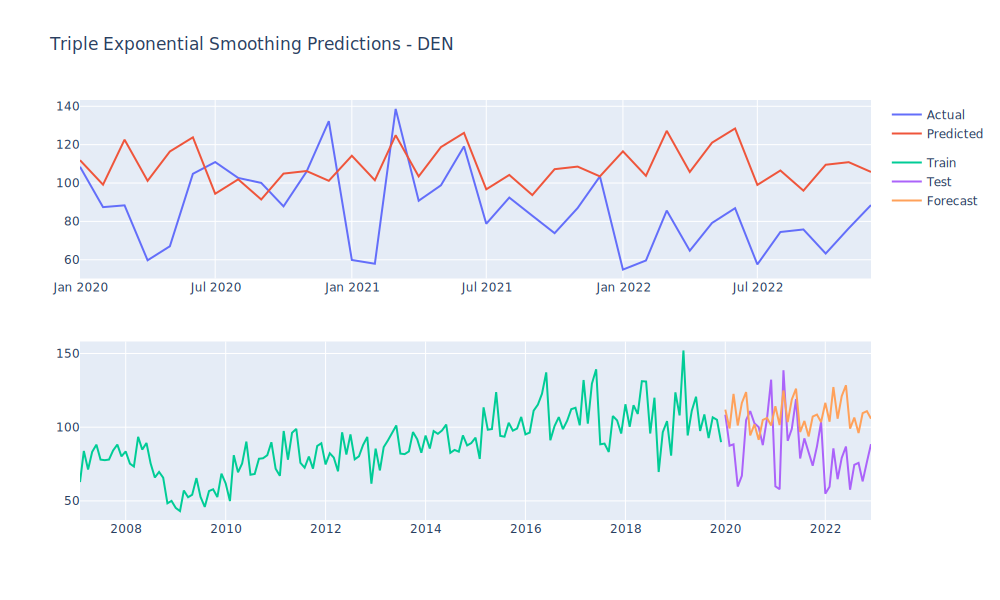

In [32]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [33]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing
Mean Absolute Error,22.715779,24.368236,26.216502
Mean Squared Error,736.196571,831.541784,962.720562
Root Mean Squared Error,27.132943,28.836466,31.027739
R^2,-0.715648,-0.937842,-1.243544
Mean Absolute Percentage Error,31.431946,33.694813,36.019880
Accuracy,68.568054,66.305187,63.980120


#### ARIMA

In [34]:
#Standard ARIMA Model
model = auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1250.564, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1840.358, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1316.929, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1668.015, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1252.461, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1252.497, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1599.598, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1251.905, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1247.231, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1330.553, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1288.594, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1248.846, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1248.995, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

In [35]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  155
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -619.616
Date:                Thu, 16 Feb 2023   AIC                           1247.231
Time:                        09:10:07   BIC                           1259.405
Sample:                    02-01-2007   HQIC                          1252.176
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2590      1.912      1.181      0.238      -1.489       6.007
ar.L1          0.9745      0.021     45.841      0.000       0.933       1.016
ma.L1         -0.7254      0.063    -11.584      0.000      -0.848      -0.603
sigma2       172.2416     16.020     10.752      0.000     140.844     203.640
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 6.96
Prob(Q):                              0.66   Prob(JB):                         0.03
Heteroskedasticity (H):               2.47   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA Model Performance:
Mean Absolute Error: 18.36.
Mean Squared Error: 499.78.
Root Mean Squared Error: 22.36.
R^2 Score = -0.16.
Mean Absolute Percentage Error: 24.75%.
Accuracy = 75.25%.


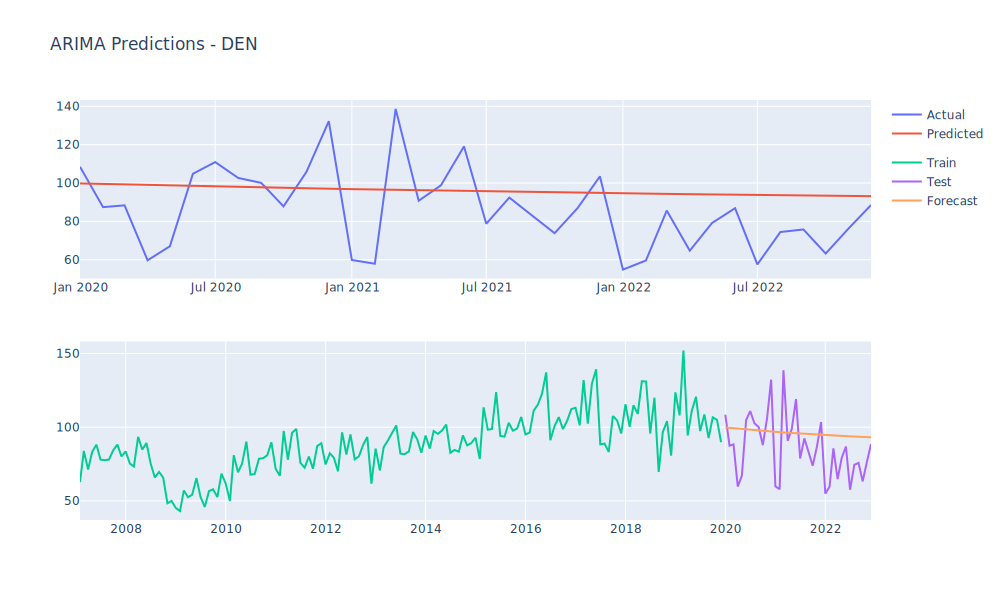

In [37]:
model_name='ARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [38]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA
Mean Absolute Error,22.715779,24.368236,26.216502,18.363616
Mean Squared Error,736.196571,831.541784,962.720562,499.784599
Root Mean Squared Error,27.132943,28.836466,31.027739,22.355863
R^2,-0.715648,-0.937842,-1.243544,-0.164709
Mean Absolute Percentage Error,31.431946,33.694813,36.019880,24.747154
Accuracy,68.568054,66.305187,63.980120,75.252846


#### SARIMA

In [39]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1095.805, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1184.811, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1128.966, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1096.570, Time=0.22 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1128.134, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1096.271, Time=0.40 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1096.272, Time=0.79 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1110.376, Time=0.17 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1098.227, Time=1.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1113.364, Time=0.21 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1094.170, Time=0.38 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1126.752, Time=0.08 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1095.334, Time=0.61 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1095.396, Time=1.18 sec
 ARIMA(2,1,1)(1,1,0

In [40]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  155
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -542.419
Date:                              Thu, 16 Feb 2023   AIC                           1092.839
Time:                                      09:10:21   BIC                           1104.662
Sample:                                  02-01-2007   HQIC                          1097.643
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7529      0.063    -12.022      0.000      -0.876      -0.630
ar.L2         -0.3833      0.065     -5.868      0.000      -0.511      -0.255
ma.S.L12      -0.6818      0.080     -8.489      0.000      -0.839      -0.524
sigma2       114.9301     11.440     10.046      0.000      92.508     137.352
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                12.52
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA Model Performance:
Mean Absolute Error: 25.95.
Mean Squared Error: 939.88.
Root Mean Squared Error: 30.66.
R^2 Score = -1.19.
Mean Absolute Percentage Error: 35.37%.
Accuracy = 64.63%.


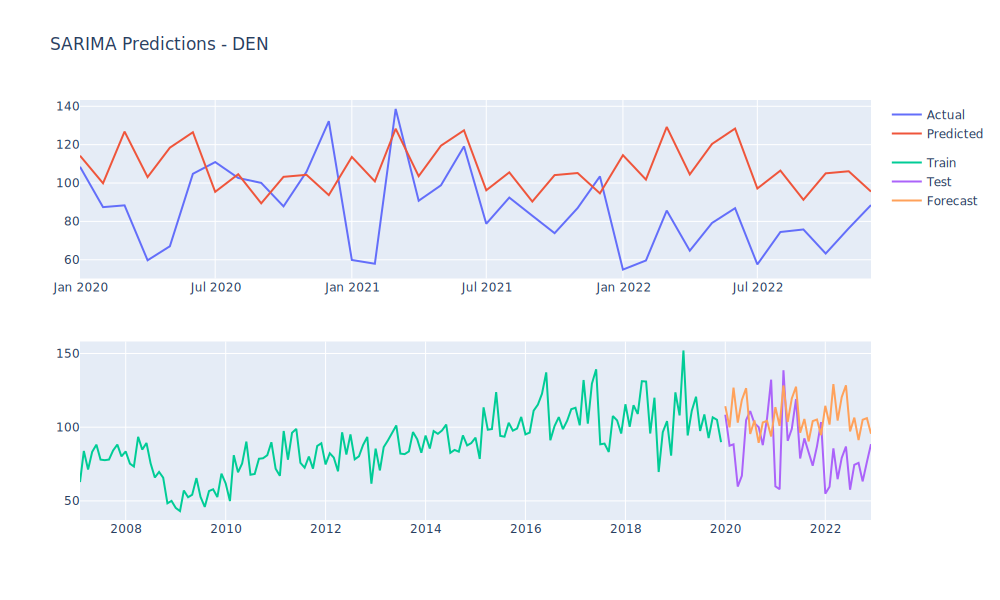

In [42]:
model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [43]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA
Mean Absolute Error,22.715779,24.368236,26.216502,18.363616,25.953352
Mean Squared Error,736.196571,831.541784,962.720562,499.784599,939.878417
Root Mean Squared Error,27.132943,28.836466,31.027739,22.355863,30.657437
R^2,-0.715648,-0.937842,-1.243544,-0.164709,-1.190312
Mean Absolute Percentage Error,31.431946,33.694813,36.019880,24.747154,35.370078
Accuracy,68.568054,66.305187,63.980120,75.252846,64.629922


#### SARIMAX

In [44]:
# SARIMAX = SARIMA with exogenous variable
model = auto_arima(train[dep_var], exogenous=train[[exo_var]],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1095.805, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1184.811, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1128.966, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1096.570, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1128.134, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1096.271, Time=0.39 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1096.272, Time=0.80 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1110.376, Time=0.18 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1098.227, Time=1.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1113.364, Time=0.20 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1094.170, Time=0.38 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1126.752, Time=0.08 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1095.334, Time=0.59 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1095.396, Time=1.13 sec
 ARIMA(2,1,1)(1,1,0

In [45]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  155
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -542.419
Date:                              Thu, 16 Feb 2023   AIC                           1092.839
Time:                                      09:10:35   BIC                           1104.662
Sample:                                  02-01-2007   HQIC                          1097.643
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7529      0.063    -12.022      0.000      -0.876      -0.630
ar.L2         -0.3833      0.065     -5.868      0.000      -0.511      -0.255
ma.S.L12      -0.6818      0.080     -8.489      0.000      -0.839      -0.524
sigma2       114.9301     11.440     10.046      0.000      92.508     137.352
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                12.52
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX Model Performance:
Mean Absolute Error: 22.67.
Mean Squared Error: 724.34.
Root Mean Squared Error: 26.91.
R^2 Score = -0.69.
Mean Absolute Percentage Error: 30.59%.
Accuracy = 69.41%.


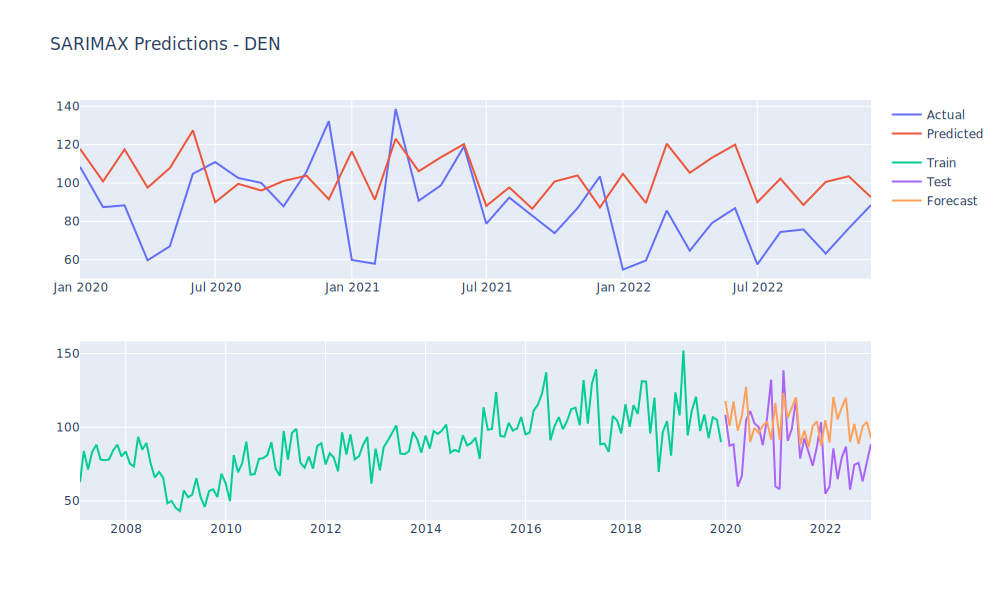

In [47]:
model_name='SARIMAX'

# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12),exog = train[exo_var]).fit()

# Predict
predictions = model.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

### Summary

In [48]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA,SARIMAX
Mean Absolute Error,22.715779,24.368236,26.216502,18.363616,25.953352,22.671056
Mean Squared Error,736.196571,831.541784,962.720562,499.784599,939.878417,724.342466
Root Mean Squared Error,27.132943,28.836466,31.027739,22.355863,30.657437,26.913611
R^2,-0.715648,-0.937842,-1.243544,-0.164709,-1.190312,-0.688023
Mean Absolute Percentage Error,31.431946,33.694813,36.019880,24.747154,35.370078,30.590372
Accuracy,68.568054,66.305187,63.980120,75.252846,64.629922,69.409628


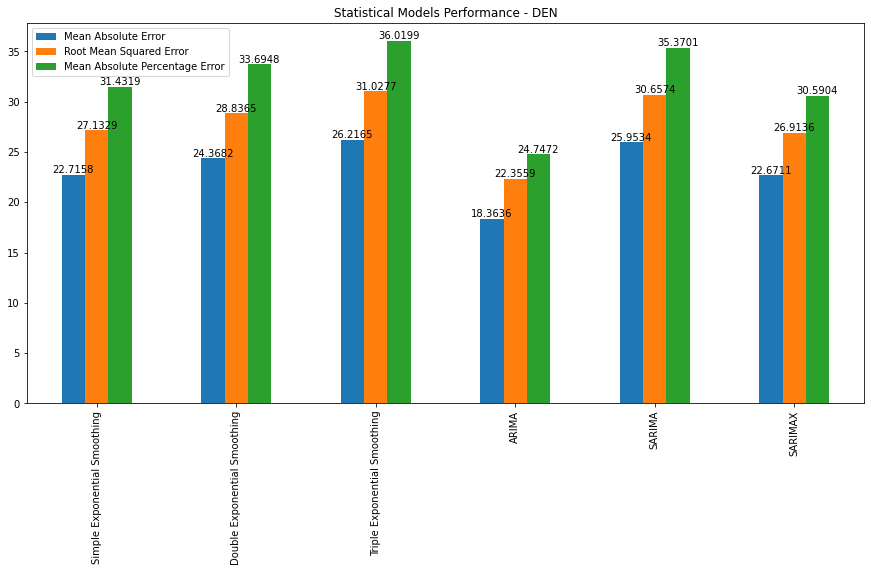

In [49]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="Statistical Models Performance - " + country, figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container)